# Imports

In [40]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

## Loading Dataset

In [2]:
# the data is from https://datahub.io/core/global-temp
df = pd.read_csv("../data/global_temperature_time_series.csv")

In [3]:
df.head()

,Source,Year,Mean
0,gcag,1850-01,-0.6746
1,gcag,1850-02,-0.3334
2,gcag,1850-03,-0.5913
3,gcag,1850-04,-0.5887
4,gcag,1850-05,-0.5088


In [4]:
df = df.drop(['Source'], axis=1).rename({'Year': 'time', 'Mean': 'temperature'}, axis=1)
df['time'] = pd.to_datetime(df['time'])

# Development

## Rolling with acending = False

In [5]:
df = df.sort_values(by='time', ascending=False)

In [6]:
df.head()

,time,temperature
3822,2024-07-01,1.1398
3821,2024-06-01,1.1154
3820,2024-05-01,1.0745
3819,2024-04-01,1.2053
3818,2024-03-01,1.2515


In [7]:
df['temperature_lag_one'] = df['temperature'].shift(-1)

In [8]:
df['temperature_lag_two_mean'] = df['temperature_lag_one'].rolling(window=2).mean()

In [9]:
df.head()

,time,temperature,temperature_lag_one,temperature_lag_two_mean
3822,2024-07-01,1.1398,1.1154,NaN
3821,2024-06-01,1.1154,1.0745,1.09495
3820,2024-05-01,1.0745,1.2053,1.13990
3819,2024-04-01,1.2053,1.2515,1.22840
3818,2024-03-01,1.2515,1.2902,1.27085


## Rolling fwith ascending = True

In [10]:
df = df.sort_values(by='time', ascending=True)

In [11]:
df['temperature_lag_one'] = df['temperature'].shift(1)

In [12]:
df['temperature_lag_two_mean'] = df['temperature_lag_one'].rolling(window=2).mean()

In [13]:
df.head()

,time,temperature,temperature_lag_one,temperature_lag_two_mean
0,1850-01-01,-0.6746,NaN,NaN
1,1850-02-01,-0.3334,-0.6746,NaN
2,1850-03-01,-0.5913,-0.3334,-0.50400
3,1850-04-01,-0.5887,-0.5913,-0.46235
4,1850-05-01,-0.5088,-0.5887,-0.59000


In [14]:
df.tail()

,time,temperature,temperature_lag_one,temperature_lag_two_mean
3818,2024-03-01,1.2515,1.2902,1.22090
3819,2024-04-01,1.2053,1.2515,1.27085
3820,2024-05-01,1.0745,1.2053,1.22840
3821,2024-06-01,1.1154,1.0745,1.13990
3822,2024-07-01,1.1398,1.1154,1.09495


In [15]:
np.mean([1.0745, 1.1154])

np.float64(1.0949499999999999)

In [16]:
x = np.arange(10) * 2
slope, _ = np.polyfit(np.arange(len(x)), x, 1)
slope

np.float64(2.0)

## Class SimpleLagTimeFeatureCreator

In [50]:
from typing import List, Dict
import warnings
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis


class SimpleLagTimeFeatureCreator:
    
    def __init__(self, windows: List[int] = [2, 3, 4], functions: List[str] = ["mean", "median", "max", "min"]):
        
        """
        Inicializa o criador de features com lag temporal.
        
        Args:
            windows: Lista de tamanhos de janela para cálculo das estatísticas
            functions: Lista de funções a serem aplicadas (mean, median, max, min, etc.)

        Raises:
            UserWarning: Se a lista de windows contiver o valor 1
        """
        
        self.windows = windows
        self.functions = functions
        
        self._function_map = {
            'mean': np.mean,
            'median': np.median,
            'max': np.max,
            'min': np.min,
            'sum': np.sum,
            'std': lambda x: np.std(x, ddof=1),
            'diff': np.ptp,
            'kurt': lambda x: kurtosis(x, bias=False),
            'skew': lambda x: skew(x, bias=False),
            'slope': self._calc_slope
        }

        if 1 in self.windows:
            warnings.warn(
                "Window size 1 was found. Windows with size equal to 1 are not recommended for lag/rolling calculations, because they do not aggregate temporal information.",
                UserWarning
            )
            self.windows.remove(1)
    
    def _calc_slope(self, x: np.ndarray) -> float:
        
        """Calcula o coeficiente angular usando mínimos quadrados."""
        
        return np.polyfit(np.arange(len(x)), x, 1)[0]

    def _create_lag_features(self, series: pd.Series) -> Dict[str, pd.Series]:
        
        """Cria todas as features com lag para uma série temporal."""
        
        lag_one = series.shift(1)
        features = {f'{series.name}_sum_1_lag': lag_one}
        
        valid_funcs = [func for func in self.functions if func in self._function_map]
        
        for func in valid_funcs:
            
            func_operation = self._function_map[func]
            
            for win in self.windows:
                
                feature_values = lag_one.rolling(window=win, min_periods=2).apply(func_operation, raw=True)
                features[f'{series.name}_{func}_{win}_lag'] = feature_values
        
        return features
    
    def calculate(self, df: pd.DataFrame, target: str, time: str) -> pd.DataFrame:
        
        """
        Calcula todas as features com lag temporal para a coluna alvo.
        
        Args:
            df: DataFrame de entrada
            target: Nome da coluna alvo para cálculo das features
            time: Nome da coluna com os dados temporais
            
        Returns:
            DataFrame com as novas features adicionadas
        """
        
        if target not in df.columns:
            raise ValueError(f"Coluna '{target}' não encontrada no DataFrame")
            
        df = df.sort_values(by=time)
        
        features = self._create_lag_features(df[target])
        
        return df.assign(**features)

In [51]:
df.head()

,time,temperature
3590,2014-08-01,0.8300
3759,2021-08-01,0.7995
3571,2013-10-01,0.6504
2836,1983-03-01,0.4100
1753,1938-01-01,0.0455


In [52]:
df = df.loc[:, ['time', 'temperature']].sample(frac=1)
df.head()

,time,temperature
2734,1978-12-01,0.0800
3019,1990-10-01,0.3865
3068,1992-11-01,0.0300
1809,1940-05-01,0.0502
1972,1947-03-01,0.0600


In [57]:
s = SimpleLagTimeFeatureCreator(windows=[2, 3, 4, 5, 6], functions=['mean', 'median', 'max', 'min', 'sum', 'std', 'diff', 'slope'])
df = s.calculate(df, 'temperature', time='time')

In [58]:
df.head()

,time,temperature,temperature_sum_1_lag,temperature_mean_2_lag,temperature_mean_3_lag,temperature_mean_4_lag,temperature_mean_5_lag,temperature_mean_6_lag,temperature_median_2_lag,temperature_median_3_lag,...,temperature_diff_2_lag,temperature_diff_3_lag,temperature_diff_4_lag,temperature_diff_5_lag,temperature_diff_6_lag,temperature_slope_2_lag,temperature_slope_3_lag,temperature_slope_4_lag,temperature_slope_5_lag,temperature_slope_6_lag
0,1850-01-01,-0.6746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1850-02-01,-0.3334,-0.6746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1850-03-01,-0.5913,-0.3334,-0.50400,NaN,NaN,NaN,NaN,-0.50400,NaN,...,0.3412,NaN,NaN,NaN,NaN,0.3412,NaN,NaN,NaN,NaN
3,1850-04-01,-0.5887,-0.5913,-0.46235,-0.533100,NaN,NaN,NaN,-0.46235,-0.5913,...,0.2579,0.3412,NaN,NaN,NaN,-0.2579,0.04165,NaN,NaN,NaN
4,1850-05-01,-0.5088,-0.5887,-0.59000,-0.504467,-0.547,NaN,NaN,-0.59000,-0.5887,...,0.0026,0.2579,0.3412,NaN,NaN,0.0026,-0.12765,-0.00002,NaN,NaN


In [59]:
df.tail()

,time,temperature,temperature_sum_1_lag,temperature_mean_2_lag,temperature_mean_3_lag,temperature_mean_4_lag,temperature_mean_5_lag,temperature_mean_6_lag,temperature_median_2_lag,temperature_median_3_lag,...,temperature_diff_2_lag,temperature_diff_3_lag,temperature_diff_4_lag,temperature_diff_5_lag,temperature_diff_6_lag,temperature_slope_2_lag,temperature_slope_3_lag,temperature_slope_4_lag,temperature_slope_5_lag,temperature_slope_6_lag
3818,2024-03-01,1.2515,1.2902,1.22090,1.263933,1.262600,1.29408,1.300700,1.22090,1.2902,...,0.1386,0.1984,0.1984,0.2684,0.2684,0.1386,-0.02990,-0.01036,-0.03666,-0.026623
3819,2024-04-01,1.2053,1.2515,1.27085,1.231100,1.260825,1.26038,1.286983,1.27085,1.2515,...,0.0387,0.1386,0.1984,0.1984,0.2684,-0.0387,0.04995,-0.01569,-0.00740,-0.027031
3820,2024-05-01,1.0745,1.2053,1.22840,1.249000,1.224650,1.24972,1.251200,1.22840,1.2515,...,0.0462,0.0849,0.1386,0.1984,0.1984,-0.0462,-0.04245,0.01224,-0.01895,-0.012097
3821,2024-06-01,1.1154,1.0745,1.13990,1.177100,1.205375,1.19462,1.220517,1.13990,1.2053,...,0.1308,0.1770,0.2157,0.2157,0.2755,-0.1308,-0.08850,-0.06933,-0.02391,-0.035860
3822,2024-07-01,1.1398,1.1154,1.09495,1.131733,1.161675,1.18738,1.181417,1.09495,1.1154,...,0.0409,0.1308,0.1770,0.2157,0.2157,0.0409,-0.04495,-0.05391,-0.05266,-0.024980


In [60]:
df.drop('time', axis=1).corr()

,temperature,temperature_sum_1_lag,temperature_mean_2_lag,temperature_mean_3_lag,temperature_mean_4_lag,temperature_mean_5_lag,temperature_mean_6_lag,temperature_median_2_lag,temperature_median_3_lag,temperature_median_4_lag,...,temperature_diff_2_lag,temperature_diff_3_lag,temperature_diff_4_lag,temperature_diff_5_lag,temperature_diff_6_lag,temperature_slope_2_lag,temperature_slope_3_lag,temperature_slope_4_lag,temperature_slope_5_lag,temperature_slope_6_lag
temperature,1.000000,0.947023,0.952519,0.953604,0.952773,0.951305,0.949995,0.952519,0.948048,0.950224,...,-0.145739,-0.184578,-0.201418,-0.210201,-0.215369,0.046722,0.062906,0.082273,0.100126,0.112289
temperature_sum_1_lag,0.947023,1.000000,0.986648,0.978893,0.973935,0.969819,0.966234,0.986648,0.975001,0.971981,...,-0.144676,-0.184319,-0.202957,-0.215500,-0.219285,0.164887,0.187896,0.193484,0.198974,0.204433
temperature_mean_2_lag,0.952519,0.986648,1.000000,0.994610,0.989882,0.986027,0.982536,1.000000,0.992433,0.988899,...,-0.146920,-0.186421,-0.204965,-0.217551,-0.222265,0.002047,0.097482,0.139880,0.162360,0.178618
temperature_mean_3_lag,0.953604,0.978893,0.994610,1.000000,0.997015,0.993733,0.990673,0.994610,0.996856,0.996267,...,-0.148095,-0.188024,-0.206273,-0.218650,-0.223709,-0.012223,0.004297,0.070285,0.111976,0.139523
temperature_mean_4_lag,0.952773,0.973935,0.989882,0.997015,1.000000,0.998045,0.995570,0.989882,0.993247,0.998869,...,-0.148817,-0.188899,-0.207171,-0.219586,-0.224717,-0.014660,-0.010489,0.006662,0.057830,0.096133
temperature_mean_5_lag,0.951305,0.969819,0.986027,0.993733,0.998045,1.000000,0.998594,0.986027,0.989766,0.996674,...,-0.148984,-0.188386,-0.206741,-0.219803,-0.225059,-0.016531,-0.016693,-0.008881,0.009130,0.051466
temperature_mean_6_lag,0.949995,0.966234,0.982536,0.990673,0.995570,0.998594,1.000000,0.982536,0.986559,0.994126,...,-0.147376,-0.187507,-0.205930,-0.219041,-0.225308,-0.017165,-0.020480,-0.017005,-0.006450,0.011793
temperature_median_2_lag,0.952519,0.986648,1.000000,0.994610,0.989882,0.986027,0.982536,1.000000,0.992433,0.988899,...,-0.146920,-0.186421,-0.204965,-0.217551,-0.222265,0.002047,0.097482,0.139880,0.162360,0.178618
temperature_median_3_lag,0.948048,0.975001,0.992433,0.996856,0.993247,0.989766,0.986559,0.992433,1.000000,0.994434,...,-0.145453,-0.187358,-0.204875,-0.216729,-0.222085,-0.022950,0.007163,0.077568,0.118494,0.145434
temperature_median_4_lag,0.950224,0.971981,0.988899,0.996267,0.998869,0.996674,0.994126,0.988899,0.994434,1.000000,...,-0.147930,-0.188861,-0.208016,-0.220001,-0.224693,-0.020710,-0.015101,0.007492,0.060712,0.098819


In [37]:
np.polyfit(np.arange(5), df['temperature_sum_1_lag'].tail().values, 1)

array([-0.05266,  1.2927 ])

<Axes: >

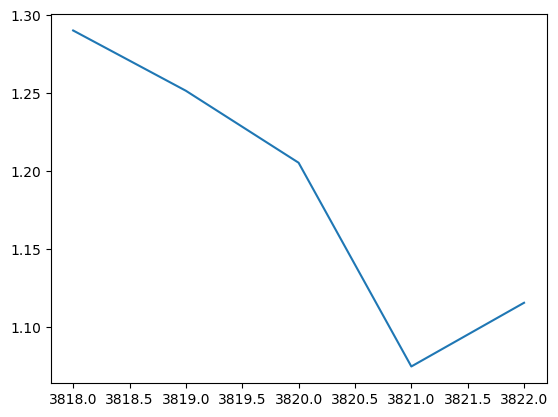

In [41]:
df['temperature_sum_1_lag'].tail().plot()

## Class AggLagTimeFeatureCreator

In [61]:
# the data is from https://datahub.io/core/global-temp
df = pd.read_csv("../data/global_temperature_time_series.csv")

In [62]:
df.head()

,Source,Year,Mean
0,gcag,1850-01,-0.6746
1,gcag,1850-02,-0.3334
2,gcag,1850-03,-0.5913
3,gcag,1850-04,-0.5887
4,gcag,1850-05,-0.5088


In [63]:
df = df.rename({'Source': 'source', 'Year': 'time', 'Mean': 'temperature'}, axis=1)

In [64]:
df['time'] = pd.to_datetime(df['time'])

In [67]:
df['source'] = df['source'].str.lower()

In [68]:
df['source'].unique()

array(['gcag', 'gistemp'], dtype=object)

In [72]:
df.query("source == 'gcag'")

,source,time,temperature
0,gcag,1850-01-01,-0.6746
1,gcag,1850-02-01,-0.3334
2,gcag,1850-03-01,-0.5913
3,gcag,1850-04-01,-0.5887
4,gcag,1850-05-01,-0.5088
...,...,...,...
3818,gcag,2024-03-01,1.2515
3819,gcag,2024-04-01,1.2053
3820,gcag,2024-05-01,1.0745
3821,gcag,2024-06-01,1.1154


In [73]:
df.query("source == 'gistemp'")

,source,time,temperature
360,gistemp,1880-01-01,-0.20
362,gistemp,1880-02-01,-0.25
364,gistemp,1880-03-01,-0.09
366,gistemp,1880-04-01,-0.16
368,gistemp,1880-05-01,-0.09
...,...,...,...
3806,gistemp,2023-08-01,1.19
3808,gistemp,2023-09-01,1.48
3810,gistemp,2023-10-01,1.34
3812,gistemp,2023-11-01,1.42


In [78]:
df['time'].value_counts()

time
2023-12-01    2
2023-11-01    2
2023-10-01    2
2023-09-01    2
2022-04-01    2
             ..
1879-12-01    1
1879-11-01    1
1879-10-01    1
1879-09-01    1
1851-08-01    1
Name: count, Length: 2095, dtype: int64